In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns

import plot_utils as pu
from digest import conds, voltage_measures, get_digest_output
import isi_indexing as ii

import conf.isi5_mouse as cfg

In [2]:
histograms = get_digest_output(cfg, 'histograms')
masked_histograms = get_digest_output(cfg, 'masked_histograms')
masked_histograms['pspike'] = histograms['pspike']
nspikes = get_digest_output(cfg, 'nspikes-neuronmean')

In [3]:
demonstrator = dict(net=26, ipair=0, istim=0)

In [4]:
width, height = 5, 10

In [5]:
labelling = {
    'pspike': 'Spike probability',
    'Activity': '$V_{static}$ (mV)',
    'Depression': '$V_{STD}$ (mV)',
    'Threshold': '$V_{TA}$ (mV)'
}
depressive_measures = ('Depression', 'Threshold')

In [6]:
def get_onset_ordering(pspike, limit=None, filter=None, **kwargs):
    if len(pspike.shape) > 3:
        pspike = ii.hist_view(cfg, pspike, **kwargs)
    elif len(pspike.shape) == 2:
        pspike = pspike[None, :, :]
    hist_sum = pspike.sum(0)
    first_index = np.sum(np.cumsum(hist_sum, axis=1) == 0, axis=1)
    safe_first_index = first_index.copy()
    safe_first_index[first_index >= hist_sum.shape[1]] = 0
    first_intensity = hist_sum[np.arange(hist_sum.shape[0]), safe_first_index]
    onset_sort = np.lexsort((-first_intensity, first_index))
    order = onset_sort[limit] if type(limit) == slice else onset_sort[:limit]
    if filter is not None:
        order = order[np.isin(order, filter)]
    tmax = np.flatnonzero(hist_sum[order].sum(axis=0))[-1] + 1
    return order, tmax

In [7]:
query = dict(**demonstrator, templ=0, isi=500, STD=1, TA=1)
selection, tmax = get_onset_ordering(histograms['pspike'], **query)

# Figure 2: Establishing deviance detection

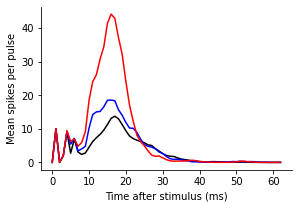

In [8]:
nspikes_time = histograms['pspike'][ii.getindex(cfg, **query)][..., :tmax].sum(1)
colors = {'std': 'k', 'dev': 'r', 'msc': 'b'}
time = np.arange(tmax) * cfg.params['dt']
plt.figure(figsize=(4.5,3))
for i, key in enumerate(conds):
    plt.plot(time/ms, nspikes_time[i], c=colors[key])
plt.xlabel('Time after stimulus (ms)')
plt.ylabel('Mean spikes per pulse')
sns.despine()

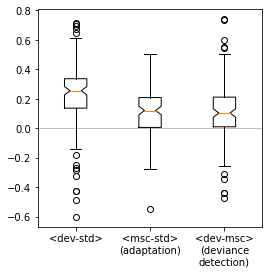

In [9]:
query = dict(isi=500, STD=1, TA=1)
n = {cond: nspikes[cond][ii.getindex(cfg, **query)[:-1]].mean(-1) for cond in ('std', 'dev', 'msc')}  # mean over pulses
def index(n0, n1):
    return ((n0-n1)/(n0+n1)).mean(0).flatten()  # mean over templates
plt.figure(figsize=(4,4))
plt.axhline(0, color='grey', lw=1, alpha=.5)
plt.boxplot((
    index(n['dev'], n['std']),
    index(n['msc'], n['std']),
    index(n['dev'], n['msc']),
), notch=True)
plt.xticks(range(1,4), ('<dev-std>', '<msc-std>\n(adaptation)', '<dev-msc>\n(deviance\ndetection)'), rotation=0);